In [21]:
import numpy as np
from utils import COLORS, load_image
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import cv2

In [22]:


video_file = "road_video.MOV"
videoCapture = cv2.VideoCapture(video_file)

# 视频帧数，分辨率
fps = videoCapture.get(cv2.CAP_PROP_FPS)
size = (int(videoCapture.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(videoCapture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
success, image = videoCapture.read()

image_height, image_width, image_channels = image.shape
image_pixels = np.reshape(image, (-1, image_channels))
_mean = np.mean(image_pixels, axis=0, keepdims=True)
_std = np.std(image_pixels, axis=0, keepdims=True)
image_pixels = (image_pixels - _mean) / _std

ncomp = int(4)

In [23]:
kmeans = KMeans(n_clusters=ncomp)
labels = kmeans.fit_predict(image_pixels)
initial_mus = kmeans.cluster_centers_
initial_priors, initial_covs = [], []
for i in range(ncomp):
    datas = np.array([image_pixels[j, :] for j in range(len(labels)) if labels[j] == i]).T
    initial_covs.append(np.cov(datas))
    initial_priors.append(datas.shape[1] / float(len(labels)))


In [24]:
class GMM():
    def __init__(self, ncomp, initial_mus, initial_covs, initial_priors):
        self.ncomp = ncomp
        self.mus = np.asarray(initial_mus)
        self.covs = np.asarray(initial_covs)
        self.priors = np.asarray(initial_priors)
        
    def inference(self, datas):
        unnormalized_probs = []
        for i in range(self.ncomp):
            mu, cov, prior = self.mus[i, :], self.covs[i, :, :], self.priors[i]
            unnormalized_prob = prior * multivariate_normal.pdf(datas, mean=mu, cov=cov)
            unnormalized_probs.append(np.expand_dims(unnormalized_prob, -1))
        preds = np.concatenate(unnormalized_probs, axis=1)
        log_likelihood = np.sum(preds, axis=1)
        log_likelihood = np.sum(np.log(log_likelihood))
        
        preds = preds / np.sum(preds, axis=1, keepdims=True)
        return np.asarray(preds), log_likelihood
    
    def update(self, datas, beliefs):
        new_mus, new_covs, new_priors = [], [], []
        soft_counts = np.sum(beliefs, axis=0)
        for i in range(self.ncomp):
            new_mu = np.sum(np.expand_dims(beliefs[:, i], -1) * datas, axis=0)
            new_mu /= soft_counts[i]
            new_mus.append(new_mu)
            
            data_shifted = np.subtract(datas, np.expand_dims(new_mu, 0))
            new_cov = np.matmul(np.transpose(np.multiply(np.expand_dims(beliefs[:, i], -1), data_shifted)),data_shifted)
            new_cov /= soft_counts[i]
            new_covs.append(new_cov)
            
            new_priors.append(soft_counts[i] / np.sum(soft_counts))
            
        self.mus = np.asarray(new_mus)
        self.covs = np.asarray(new_covs)
        self.priors = np.asarray(new_priors)
        
        

In [25]:
gmm = GMM(ncomp, initial_mus, initial_covs, initial_priors)

In [26]:
prev_log_likelihood = None
for i in range(1000):
    beliefs, log_likelihood = gmm.inference(image_pixels)
    gmm.update(image_pixels, beliefs)
    print('Iteration {}: Log Likelihood = {}'.format(i+1, log_likelihood))
    if prev_log_likelihood != None and abs(log_likelihood - prev_log_likelihood) < 1e-10:
        break
    prev_log_likelihood = log_likelihood

Iteration 1: Log Likelihood = 216756.51982299265
Iteration 2: Log Likelihood = 1031477.7014388692
Iteration 3: Log Likelihood = 1575370.0871260734
Iteration 4: Log Likelihood = 2140638.1922692535
Iteration 5: Log Likelihood = 2557689.251689941
Iteration 6: Log Likelihood = 2761079.283955047
Iteration 7: Log Likelihood = 2844577.421019008
Iteration 8: Log Likelihood = 2874714.7101720395
Iteration 9: Log Likelihood = 2886291.1311887926
Iteration 10: Log Likelihood = 2891087.8311243462
Iteration 11: Log Likelihood = 2893391.979605935
Iteration 12: Log Likelihood = 2894768.929899567
Iteration 13: Log Likelihood = 2896120.7766181147
Iteration 14: Log Likelihood = 2900707.060066023
Iteration 15: Log Likelihood = 2916750.2861613147
Iteration 16: Log Likelihood = 2934830.6967898807
Iteration 17: Log Likelihood = 2944701.1339116013
Iteration 18: Log Likelihood = 2948052.6323864954
Iteration 19: Log Likelihood = 2949251.4142432213
Iteration 20: Log Likelihood = 2949738.5218792604
Iteration 21: L

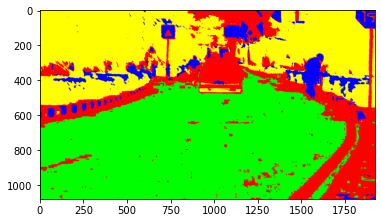

In [27]:
beliefs, log_likelihood = gmm.inference(image_pixels)
map_beliefs = np.reshape(beliefs, (image_height, image_width, ncomp))
segmented_map = np.zeros((image_height, image_width, 3))
for i in range(image_height):
    for j in range(image_width):
        hard_belief = np.argmax(map_beliefs[i, j, :])
        segmented_map[i, j, :] = np.asarray(COLORS[hard_belief]) / 255.0
plt.imshow(segmented_map)
plt.show()

## 由肉眼可见，k=4时，聚类效果最好。
